In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from networks import AdditiveNoisyNet
from noise_generator import GaussianNoiseGenerator
from noise_transformer import ConstantNoiseTransformer, BlockNoiseTransformer
from data import generate_data
from torch.utils.data import TensorDataset
from train import Trainer

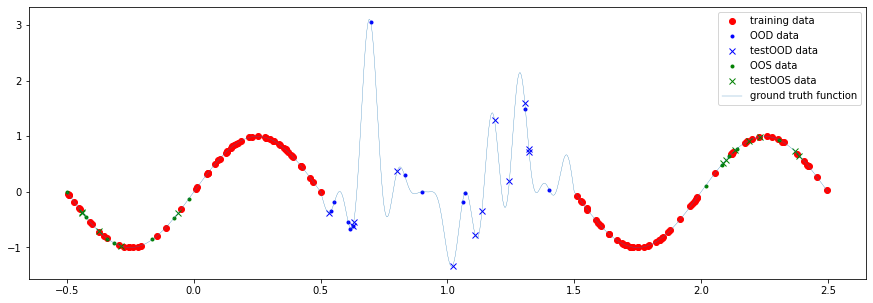

In [4]:
x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test, x_test, y_test = generate_data(plot=True,
                                                                                                                 seed=8)

In [121]:
input_dim = 1
output_dim = 1
n_hidden = 128
hidden_layers = 3
activation_fn = nn.ReLU

lr = 1e-3
batch_size = 64

size = 1
noise_model = nn.Sequential(nn.Linear(input_dim, n_hidden), activation_fn(),
                           #nn.Linear(n_hidden, n_hidden), activation_fn(),
                           nn.Linear(n_hidden, size))
noise_generator = GaussianNoiseGenerator(size=size, model=noise_model, model_out='logsigma')
noise_transformer = ConstantNoiseTransformer(output_dim + n_hidden * hidden_layers)
# noise_transformer = BlockNoiseTransformer(output_dim + n_hidden * hidden_layers, B=32)

model = AdditiveNoisyNet(input_dim, n_hidden, hidden_layers, output_dim, activation_fn, noise_generator, noise_transformer)
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'noise_generator' not in x], lr=lr)
deup_optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'noise_generator' in x
                                   and 'mu' not in x], lr=lr)

train_dataset = TensorDataset(x, y)
validation_dataset = TensorDataset(oos_x, oos_y)
deup_dataset = TensorDataset(torch.cat([oos_x, ood_x]), torch.cat([oos_y, ood_y]))

trainer = Trainer(model, optimizer, train_dataset, validation_dataset, batch_size, deup_optimizer=deup_optimizer,
                 deup_dataset=deup_dataset)


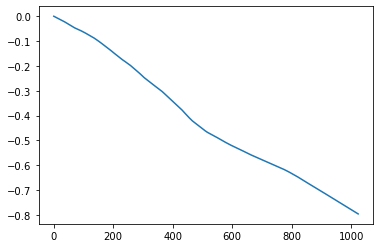

In [122]:
plt.plot(noise_generator.model(x_test).detach().squeeze())

In [123]:
list(map(lambda x: x.squeeze(), noise_generator(x)))

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>),
 tensor([-0.2473, -0.2089, -0.1353, -0.1492, -0.2190, -0.1740, -0.2142, -0.1205,
         -0.1871, -0.2404, -0.1774, -0.2588, -0.1691, -0.2731, -0.1351, -0.2203,
         -0.1221, -0.1897, -0.2086, -0.1343, -0.2461, -0.2692, -0.2578, -0.2360,
         -0.1653, -0.1715, -0.1446, -0.1676, -0.1970, -0.2445, -0.2570, -0.1586,
         -0.1510, -0.2817, -0.2263, -0.2361, -0.2334, -0.1600, -0.2073, -0.1358,
       

In [124]:
trainer.train(epochs=500, sigma=1.)


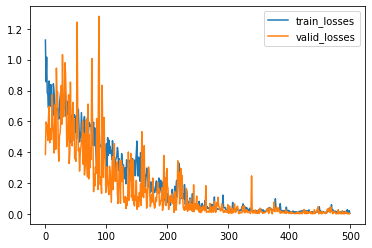

In [125]:
plt.plot(trainer.train_losses, label='train_losses')
plt.plot(trainer.valid_losses, label='valid_losses')
plt.legend()
plt.show()


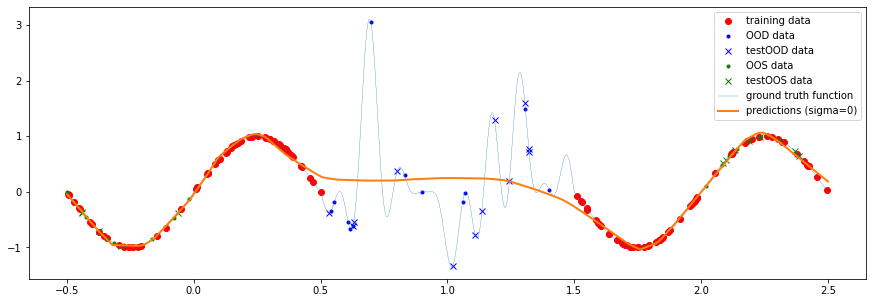

In [126]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.plot(x_test, model(x_test
                       , sigma=0., fixed_noise=True,
                      ).detach(), linewidth=2., label='predictions (sigma=0)')
# plt.plot(x_test, torch.stack([model.sample(x_test, fixed_noise=True).detach().squeeze() for _ in range(15)], 0).mean(0),
#          label='average samples (sigma=1)')
        
plt.legend()


In [163]:
noise_model = nn.Sequential(nn.Linear(input_dim, n_hidden), activation_fn(),
                           nn.Linear(n_hidden, n_hidden), activation_fn(),
                           nn.Linear(n_hidden, n_hidden), activation_fn(),
                           nn.Linear(n_hidden, size))
noise_generator = GaussianNoiseGenerator(size=size, model=noise_model, model_out='logsigma')
model.noise_generator = noise_generator
model.deup_optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'noise_generator' in x
                                   #and 'mu' not in x
                                        ], lr=lr)
trainer.deup_losses = []


In [164]:
trainer.train_deup(1000, K=5)

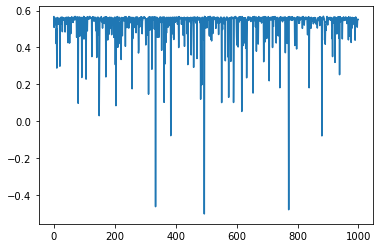

In [165]:
plt.plot(trainer.deup_losses)


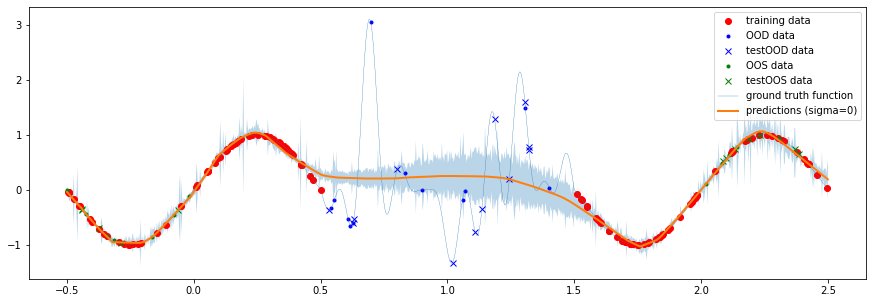

In [166]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)

mean = model(x_test, sigma=0., fixed_noise=True,).detach().squeeze()
plt.plot(x_test, mean, linewidth=2., label='predictions (sigma=0)')
uncertainties = model.get_uncertainties(x_test, K=20).detach().squeeze()
plt.fill_between(x_test.squeeze(), mean - uncertainties, mean + uncertainties, alpha=.3)
        
plt.legend()


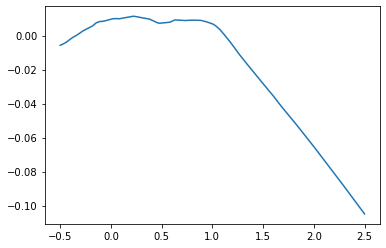

In [169]:
plt.plot(x_test.squeeze(), model.noise_generator(x_test)[1].detach().squeeze())
